In [1]:
import os 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
import warnings


from utils import *

from sensor_params import *

from models.training import *

from models.multi_step.unet1D_regressor import *
from models.multi_step.unet1D_regressor import get_model as get_unet1D

# from models.multi_step.unet1D_DIL_regressor import *
# from models.multi_step.unet1D_DIL_regressor import get_model as get_DIL_unet1D

from models.multi_step.LSTMVanilla import *
from models.multi_step.LSTMVanilla import get_model as get_LSTM

from models.multi_step.StackedLSTM import *
from models.multi_step.StackedLSTM import get_model as get_StackedLSTM

# from models.multi_step.unet1D_LSTM_regressor import *
# from models.multi_step.unet1D_LSTM_regressor import get_model as get_unet1DLSTM

# from models.multi_step.unet1D_nonCompres_regressor import *
# from models.multi_step.unet1D_nonCompres_regressor import get_model as get_unet1D_nonCompres

from evaluation.multi_step import *


# Dataset path 
DATABASE_PATH = r"C:\Users\aralmeida\OneDrive - Universidad de Las Palmas de Gran Canaria\Doctorado\Bases de datos\WARIFA\Mikael T1DM"

filename = "MIKAEL_data.json"

parent_directory = r"C:\Users\aralmeida\Downloads"
experiments_folder = r"\T1DM_pred_experiments" 

In [2]:
# Load data from sgv_data. If executed, comment the line and load the data from the pickle file
# data , basal_data_dict, blood_pressure_dict, bolus_data_dict, exercise_data_dict, carbohydrates_data_dict, pump_events_data_dict, sgv_data_dict, sleep_data_dict, smgb_data_dict, steps_data_dict, weight_dict  = extract_Mikael_data(DATABASE_PATH, filename, ONLY_CGM = True)
with open(DATABASE_PATH+'\CGM.pk1', 'rb') as f:
    sgv_data_dict = pickle.load(f)
os.chdir(parent_directory)

In [3]:
N = 144
tau = 1
PH = 60
pred_steps = round(PH/5)
name = 'StackedLSTM-minmax-himar-rep'

In [4]:
X, Y, X_times, Y_times = get_CGM_X_Y_multistep(sgv_data_dict, sensor_Mikael, N, tau, PH, experiments_folder, plot=False, verbose = 0)

Number of blocks is 335



In [5]:
# Convert np.arrays to float32 to convert them to Tensorflow tensors
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [6]:
# Min-max normalization
X_norm = (X - np.min(X))/(np.max(X) - np.min(X))
Y_norm = (Y - np.min(X))/(np.max(X) - np.min(X))

In [7]:
# Simple partition (imitating Himar work for comparison): X_train until 30/05/2021 and X_test from 31/05/2021
# Samples that include two days are removed
X_train = X_norm[np.where(X_times[:,N-1] <= pd.to_datetime('2021-05-31 00:00:00'))[0]]
Y_train = Y_norm[np.where((Y_times[:,0] < pd.to_datetime('2021-05-30 23:59:59')))[0]]
X_test = X_norm[np.where((X_times[:,N-1] > pd.to_datetime('2021-06-01 00:00:00')))[0]]
Y_test = Y[np.where((Y_times[:,0] > pd.to_datetime('2021-06-01 00:00:00')))[0]] # Left non-normalized to compute the metrics

print("X_train shape: ",str(X_train.shape))
print("Y_train shape: ",str(Y_train.shape))
print("X_test shape: ",str(X_test.shape))
print("Y_test shape: ",str(Y_test.shape))

X_train shape:  (113418, 144)
Y_train shape:  (113418, 12)
X_test shape:  (42797, 144)
Y_test shape:  (42797, 12)


In [8]:
# Parameters for training
# Best parameters for the model N 48
lr = 0.0001
batch_size = 2
epochs = 10

kernel_size = 3

# lr = 0.001
# batch_size = 2
# epochs = 10
# kernel_size = 3

In [9]:
# Get model instance
model =  get_unet1D(N=N,
                input_features = NUMBER_OF_INPUT_SIGNALS,
                tau=tau,
                kernel_size=kernel_size,
                predicted_points=pred_steps)

# model =  get_unet1D_nonCompres(N=N,
#                 input_features = NUMBER_OF_INPUT_SIGNALS,
#                 tau=tau,
#                 kernel_size=kernel_size,
#                 predicted_points=1)

# model =  get_DIL_unet1D(N=N,
#                 input_features = NUMBER_OF_INPUT_SIGNALS,
#                 tau=tau,
#                 kernel_size=kernel_size,
#                 dilation_rate=1,  
#                 predicted_points=1)

# model =  get_LSTM(N=int(N),
#                 input_features = NUMBER_OF_INPUT_SIGNALS,
#                 tau=tau,
#                 kernel_size=kernel_size,
#                 predicted_points=pred_steps)

model =  get_StackedLSTM(N=N,
                input_features = NUMBER_OF_INPUT_SIGNALS,
                predicted_points=pred_steps)

# model =  get_unet1DLSTM(N=N,
#                 input_features = NUMBER_OF_INPUT_SIGNALS,
#                 tau=tau,
#                 kernel_size=kernel_size,
#                 predicted_points=1)

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 144, 1)]          0         
                                                                 
 lstm (LSTM)                 (None, 144, 72)           21312     
                                                                 
 lstm_1 (LSTM)               (None, 36)                15696     
                                                                 
 dense_2 (Dense)             (None, 12)                444       
                                                                 
Total params: 37,452
Trainable params: 37,452
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_model(model,
            X = X_train,
            Y = Y_train,
            N = N,
            tau = tau,             
            kernel_size = kernel_size,
            predicted_points = pred_steps, #sensor_Mikael["PREDICTED_POINTS"],
            sensor_name = sensor_Mikael,
            epochs = epochs,
            batch_size = batch_size,
            lr = lr,
            verbose = 1, 
            fold = name)

In [13]:
os.chdir(r"C:\Users\aralmeida\Downloads\T1DM_pred_experiments\N144_stride1_step12\training")

1338/1338 [==============================] - 37s 27ms/step
StackedLSTM-minmax-himar-rep Test RMSE in all time steps:   24.887379
StackedLSTM-minmax-himar-rep Test MAE in all time steps:   16.631756
StackedLSTM-minmax-himar-rep Test MAPE in all time steps:   14.035531878471375


StackedLSTM-minmax-himar-rep Test RMSE in each time step:   [ 5.718676  8.638457 12.464253 16.334982 19.184666 22.137245 25.259806
 27.805256 30.684319 32.80968  35.32494  36.984684]
StackedLSTM-minmax-himar-rep Test MAE in each time step:   [ 4.055621  5.608502  8.578136 11.375898 13.554672 15.927993 18.34258
 20.445728 22.758968 24.571398 26.410782 27.951065]
StackedLSTM-minmax-himar-rep Test MAPE in each time step:   [ 3.382243   4.701142   7.185015   9.230586  11.32924   13.437429
 15.2690325 17.297916  19.135593  21.132343  22.15655   24.169218 ]


c:\Users\aralmeida\OneDrive - Universidad de Las Palmas de Gran Canaria\Doctorado\codigo\T1DM_WARIFA\evaluation\multi_step\evaluation.py:400: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


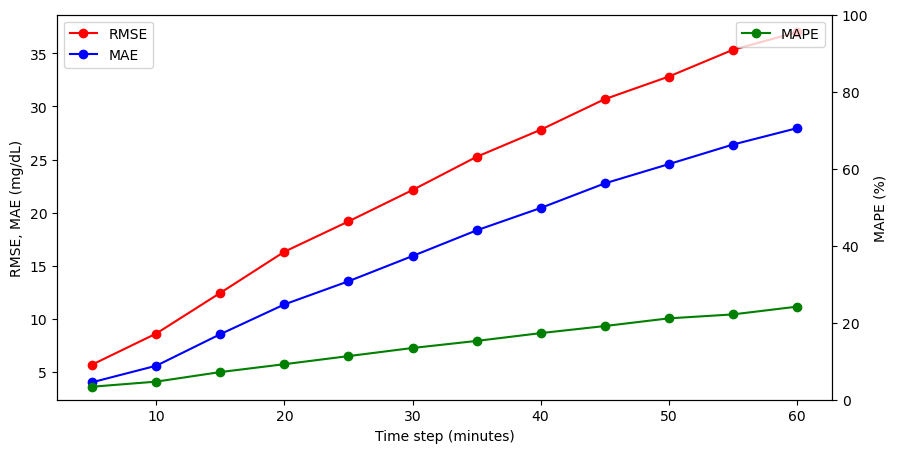

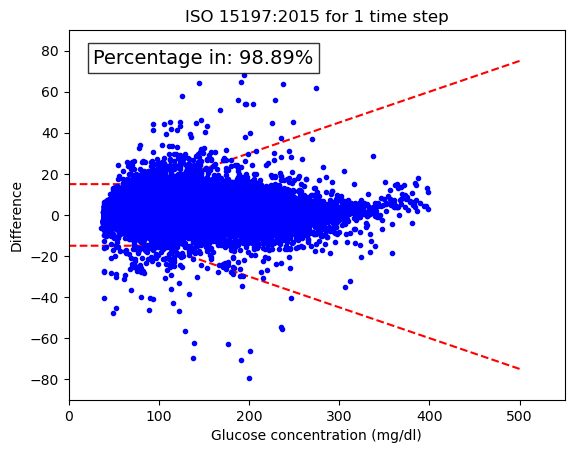

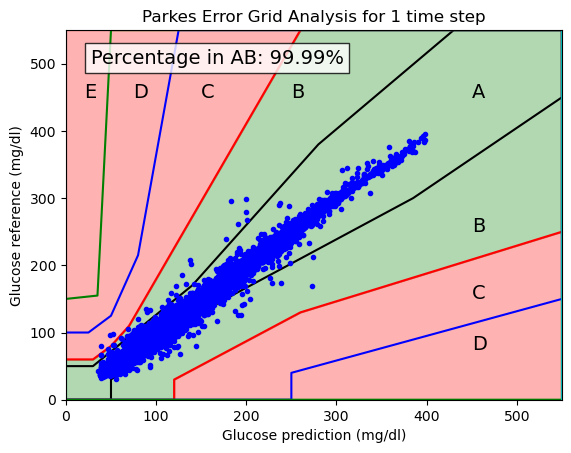

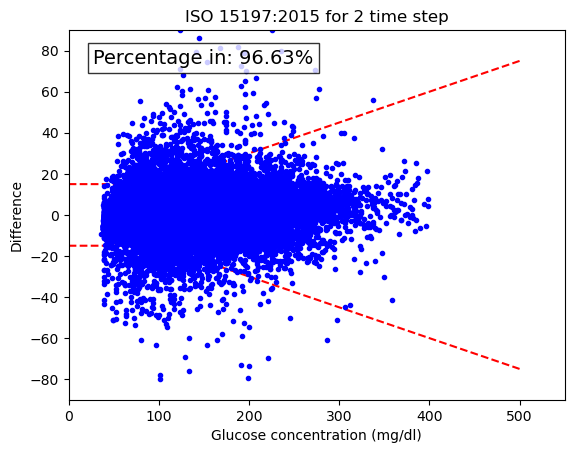

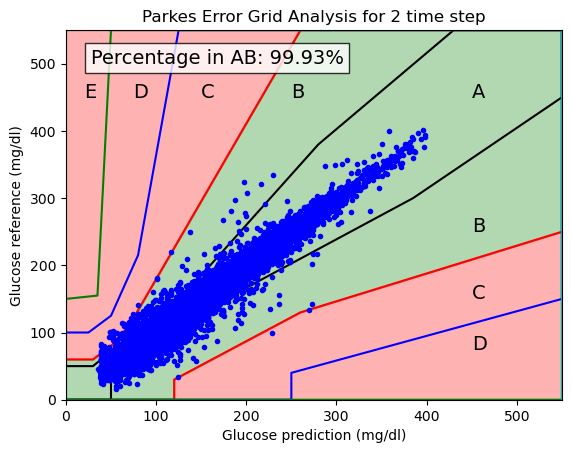

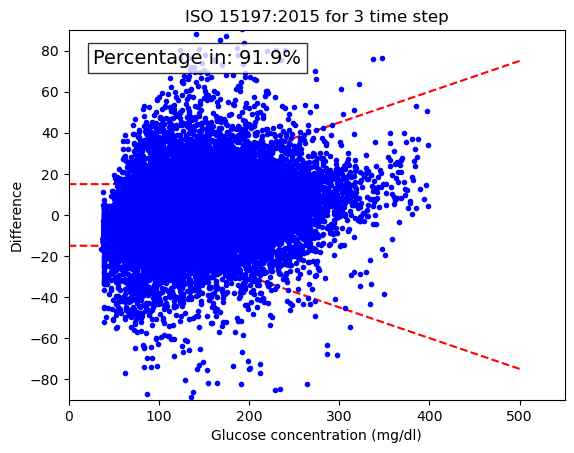

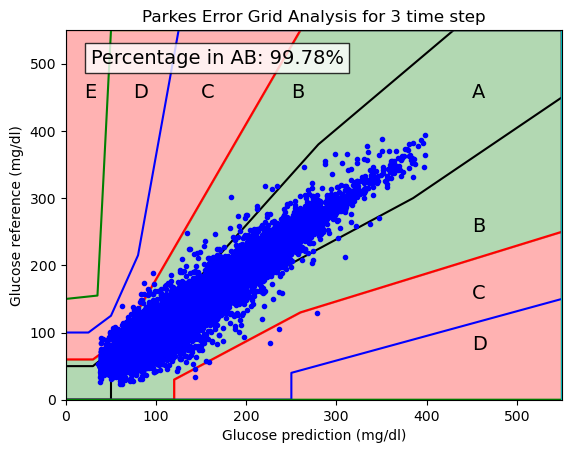

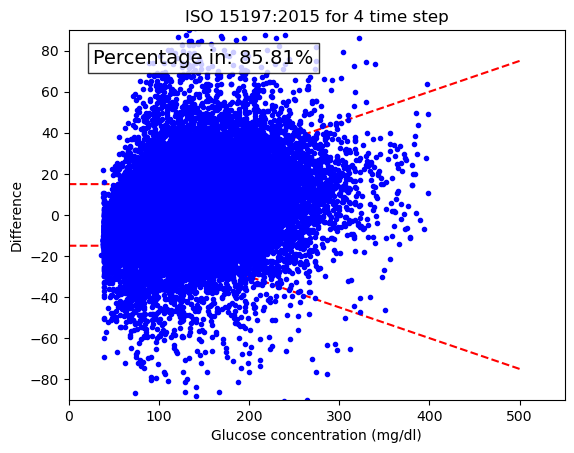

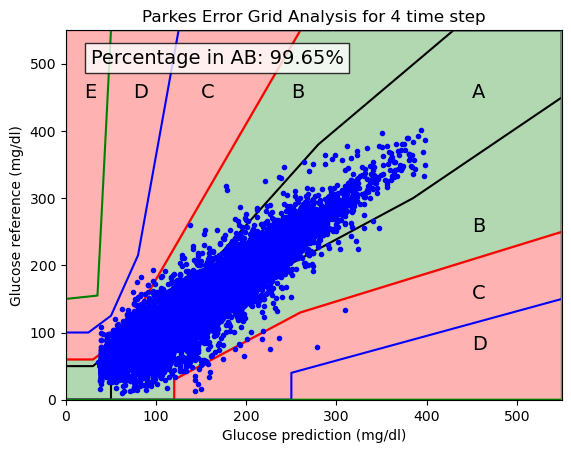

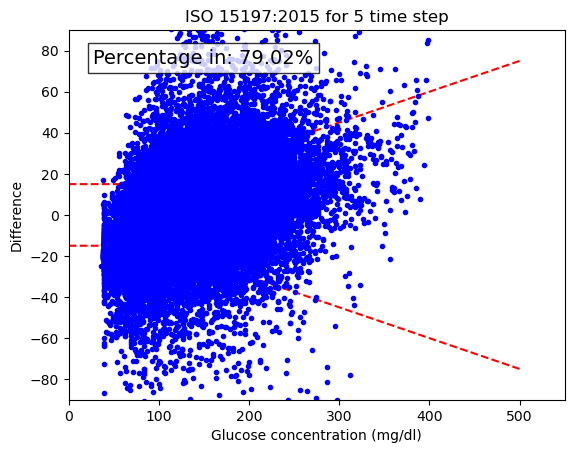

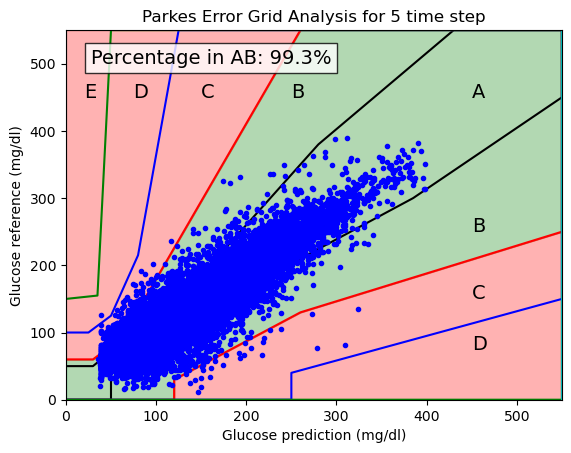

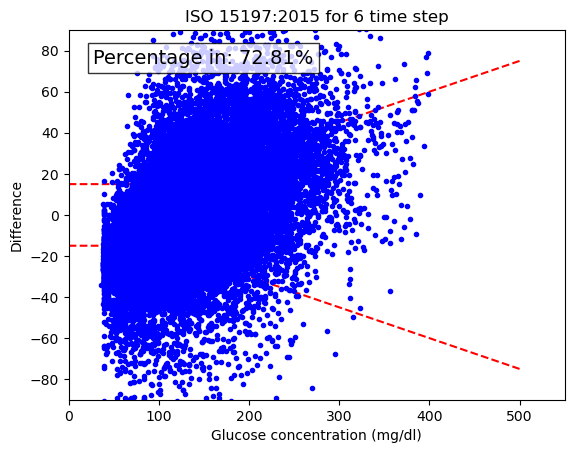

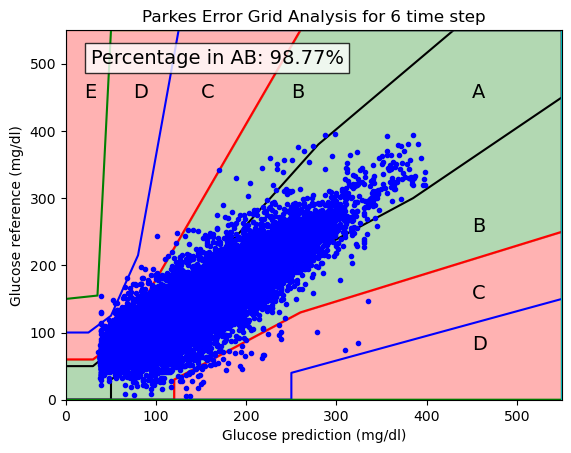

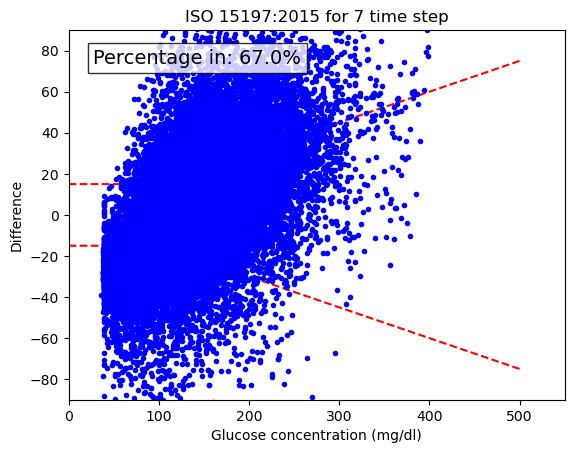

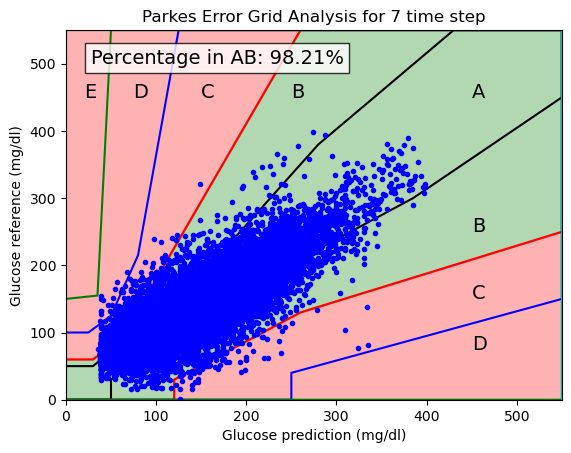

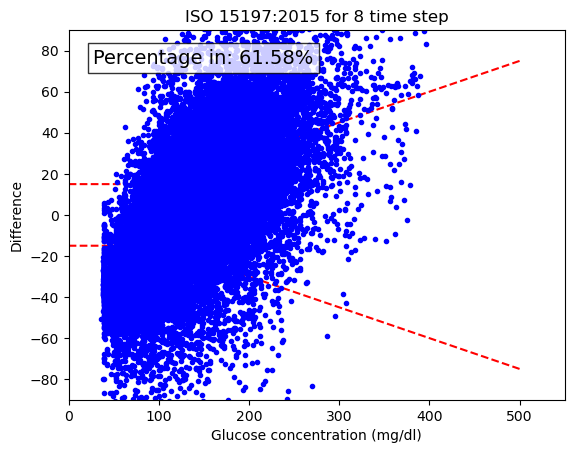

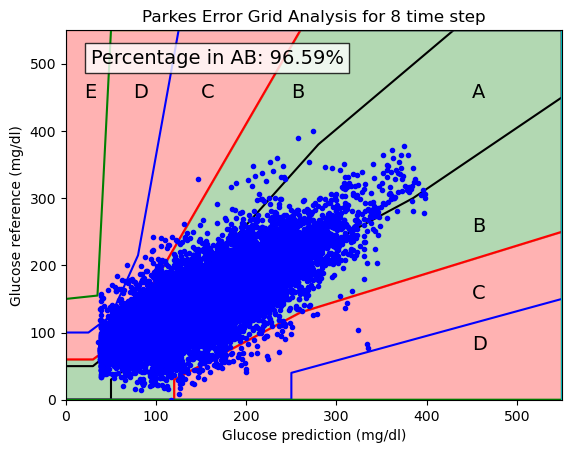

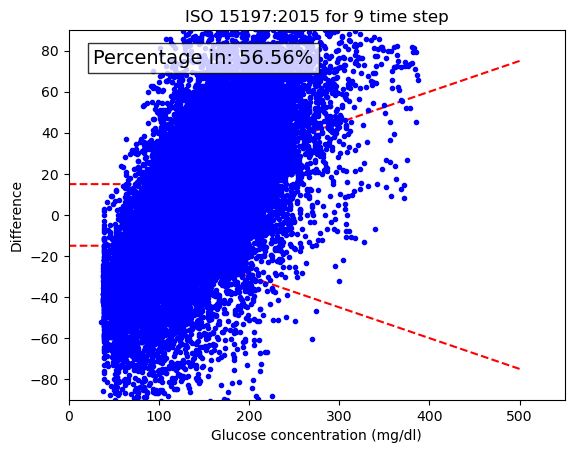

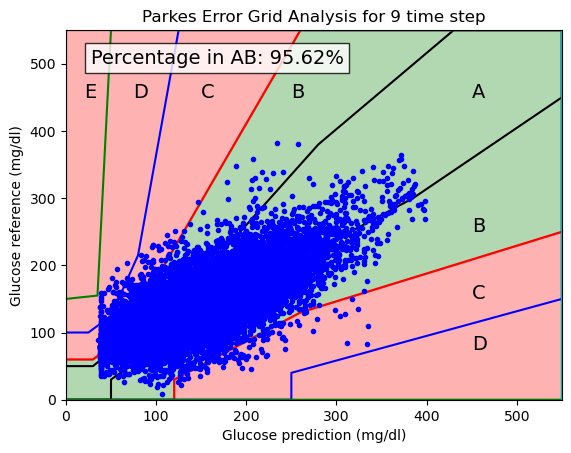

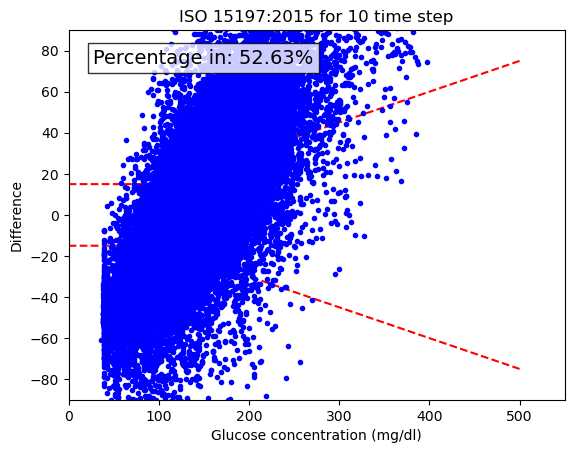

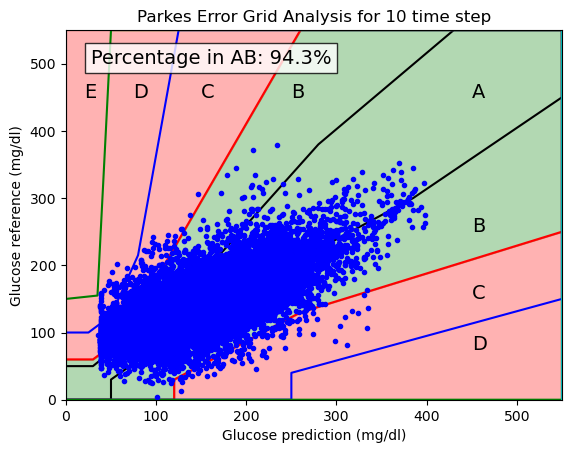

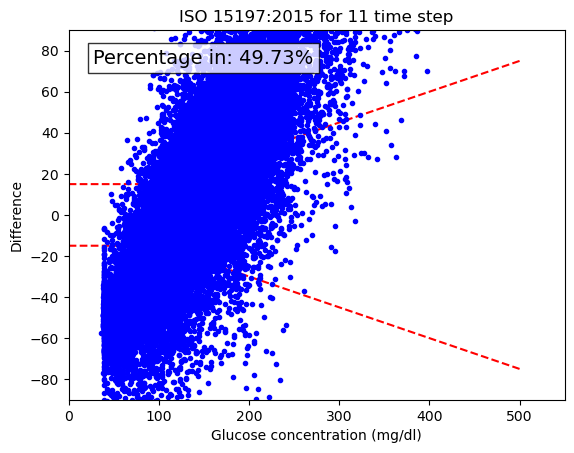

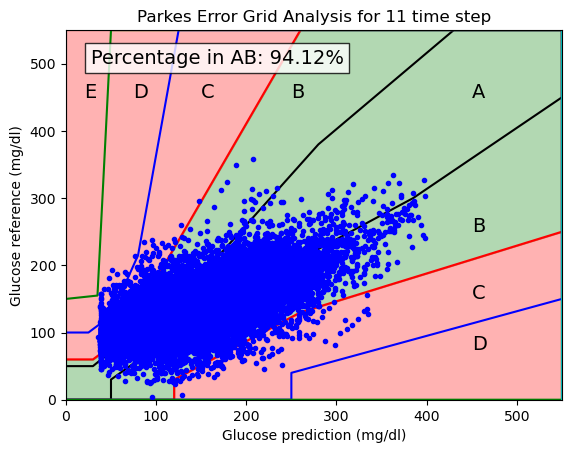

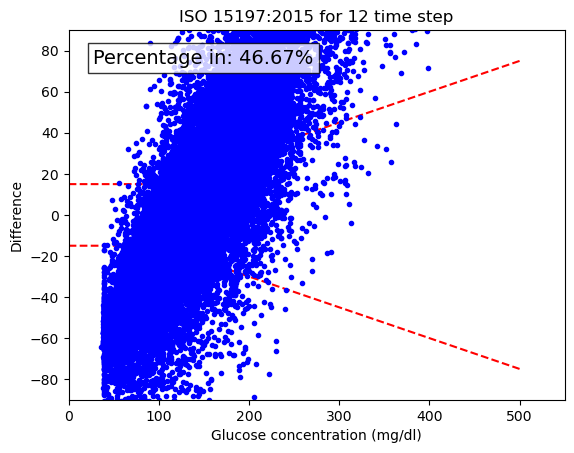

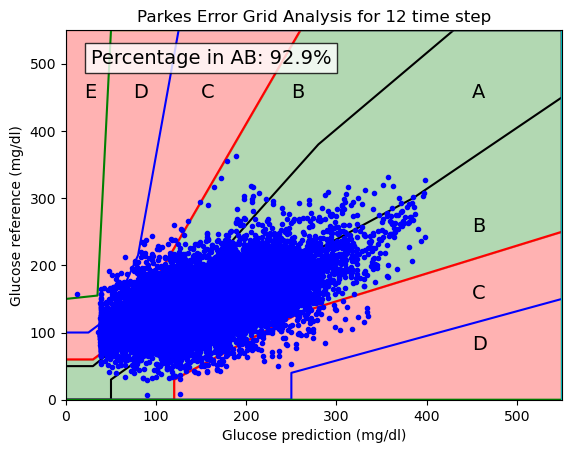

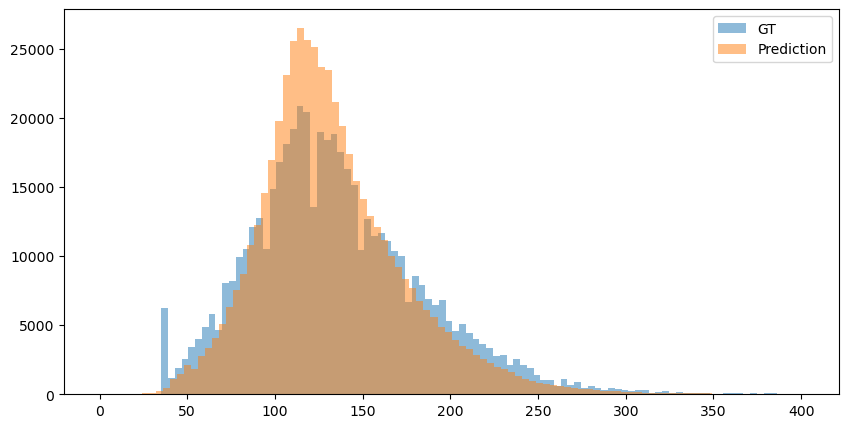

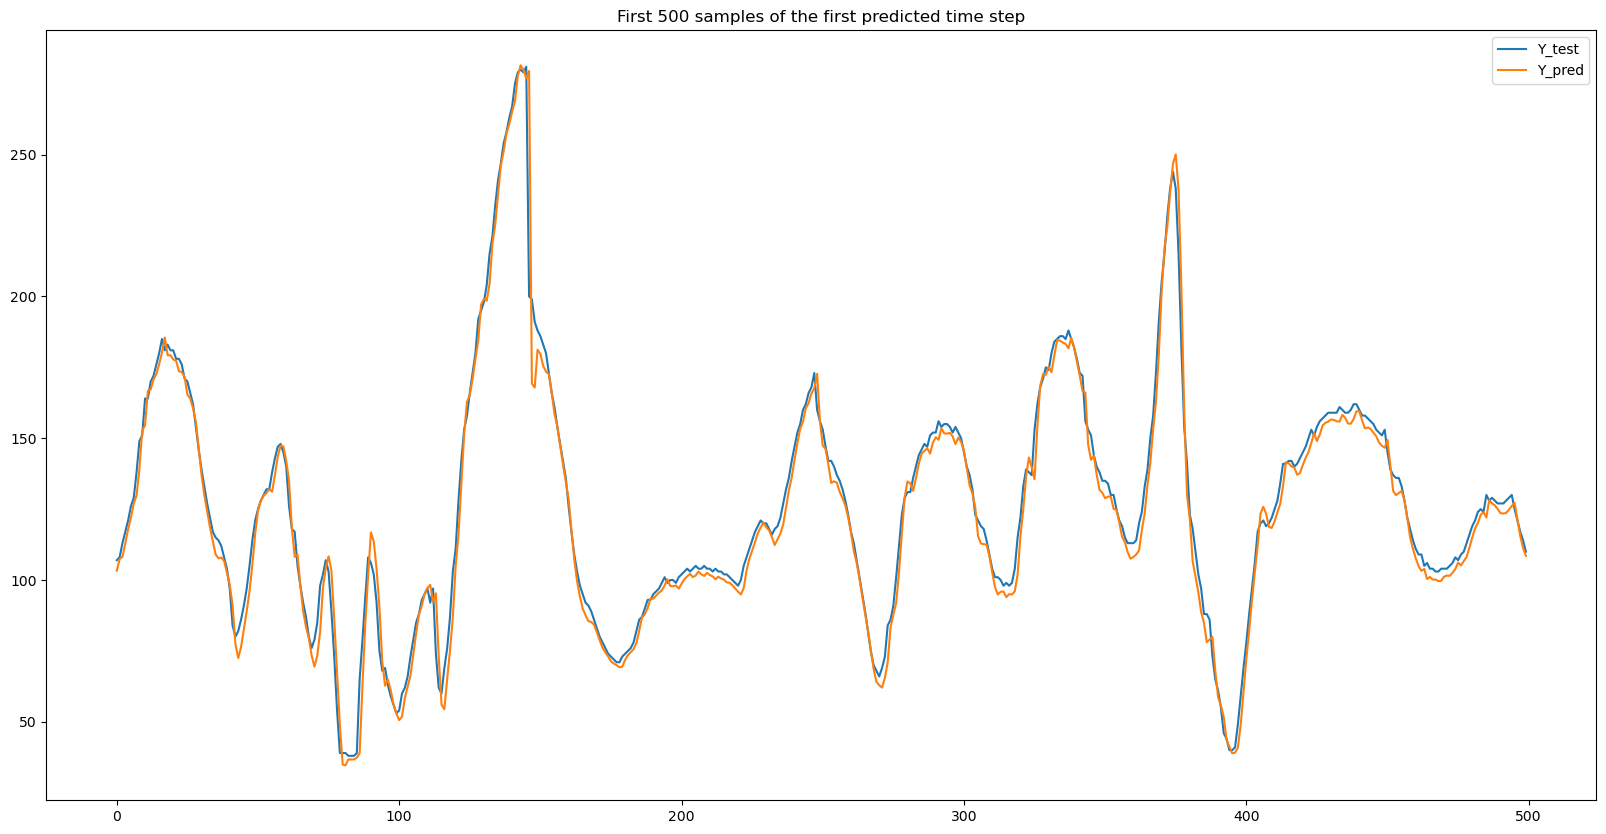

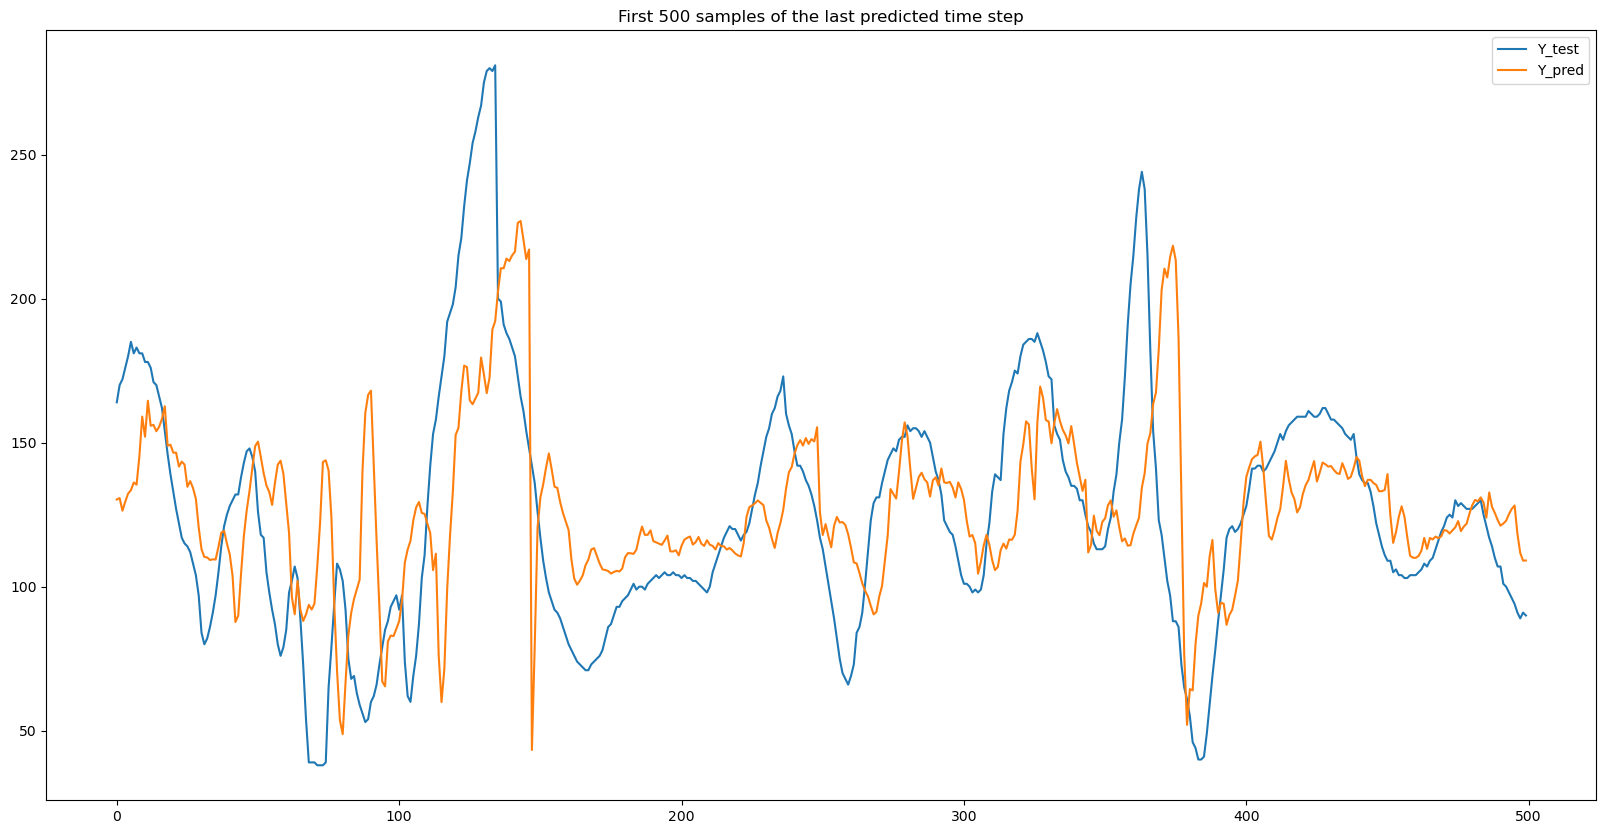

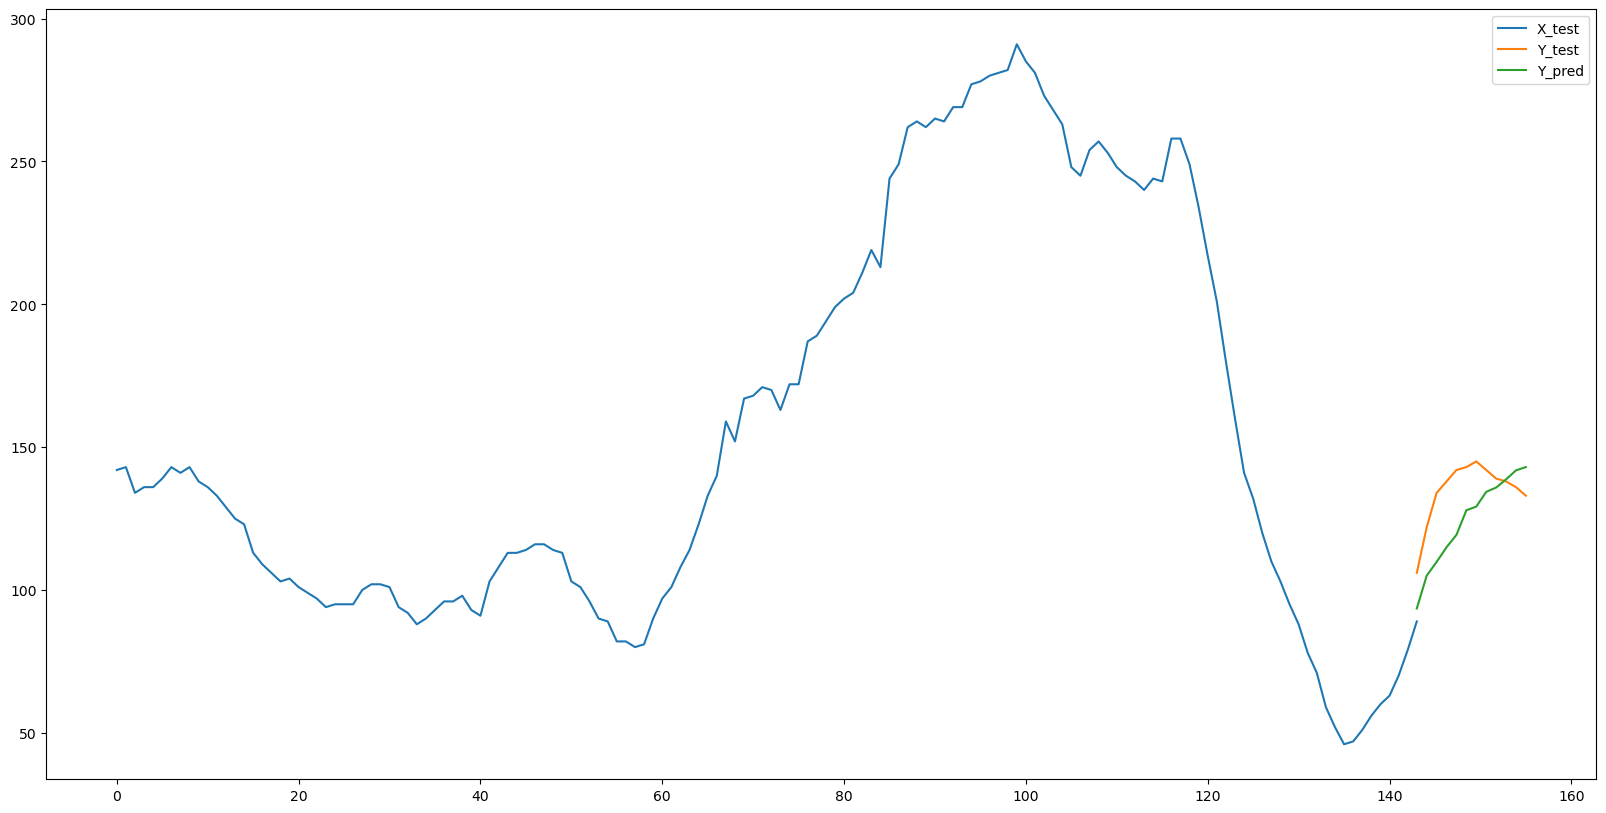

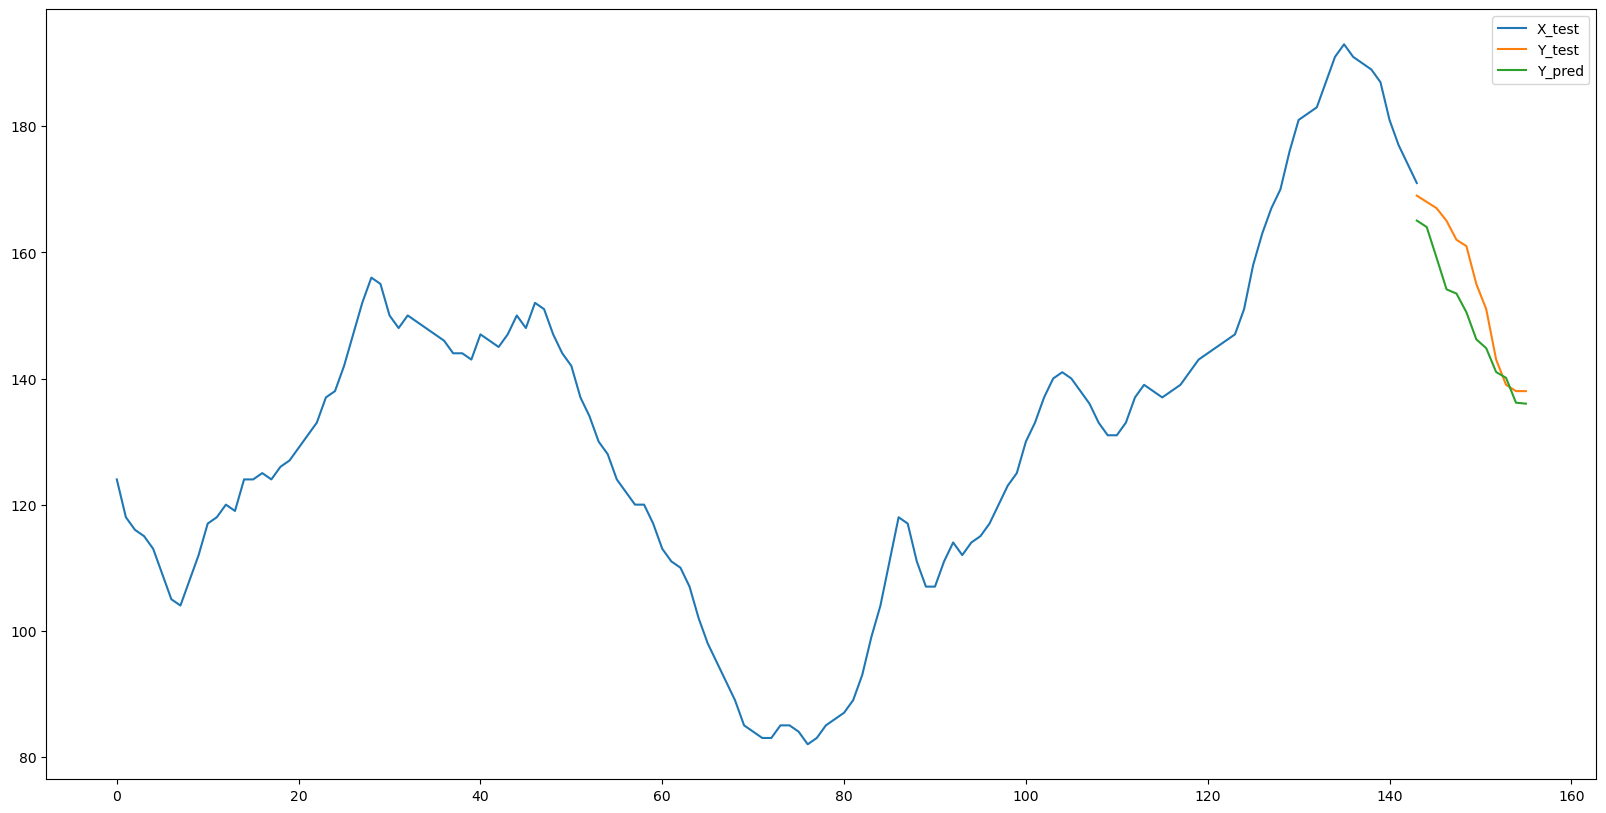

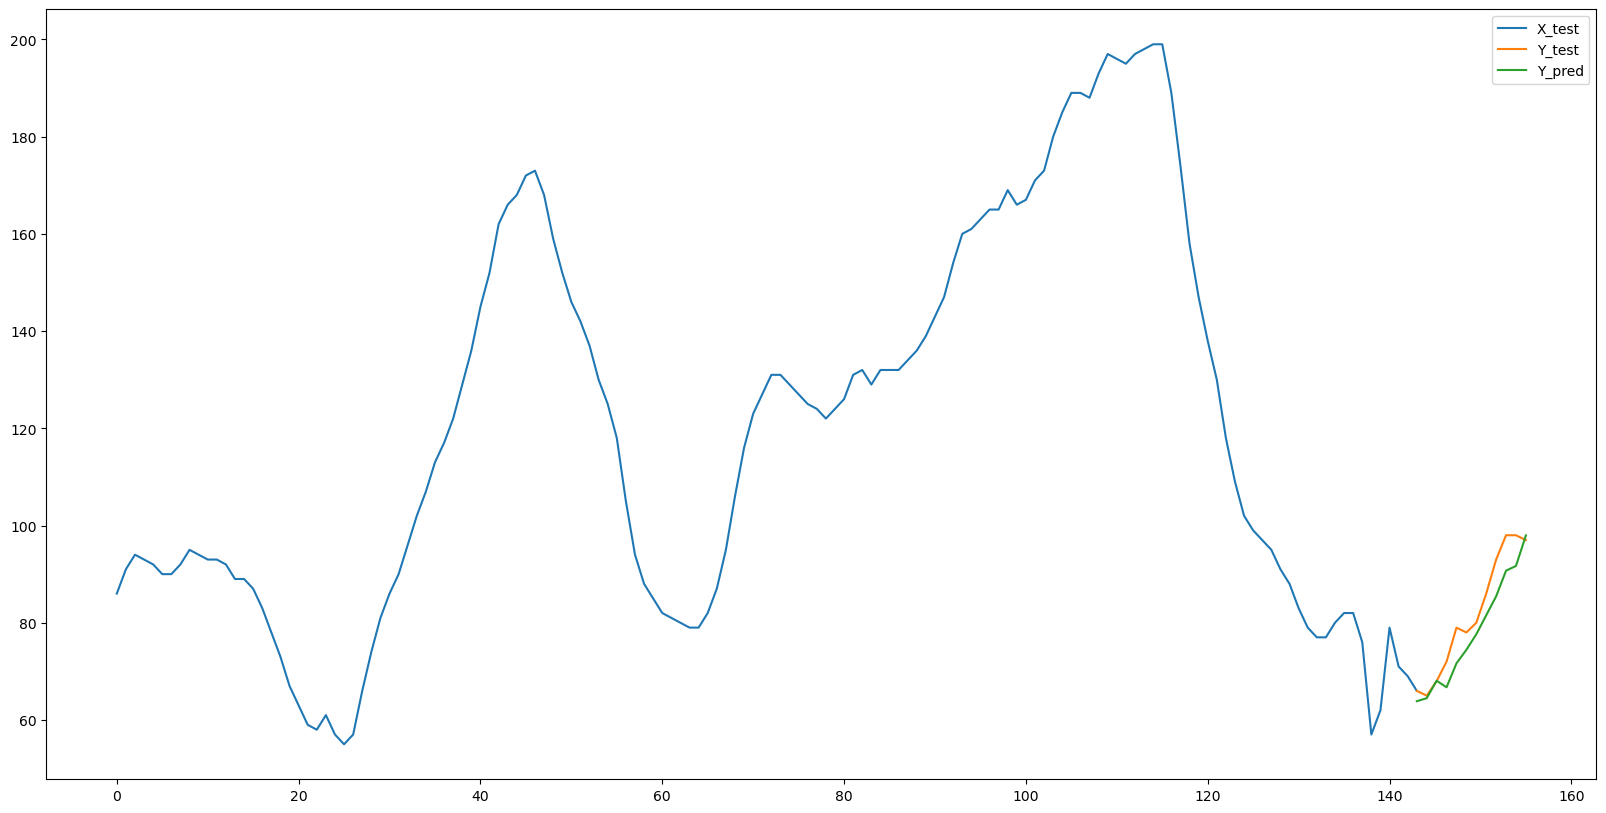

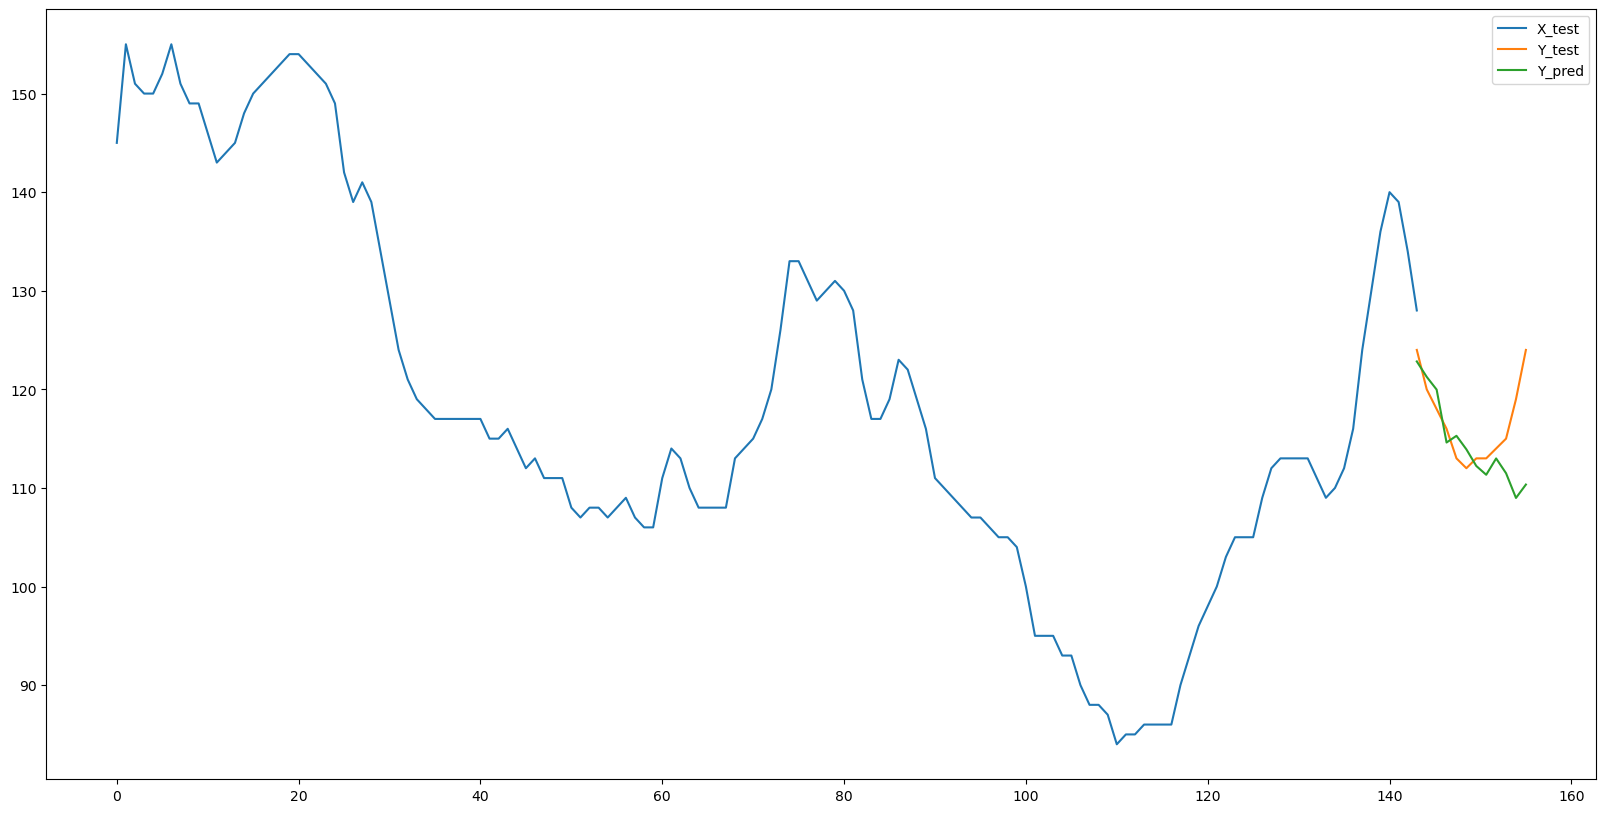

In [14]:
model_evaluation(N, PH, name, X_test, Y_test, pred_steps, X) 
# 